In [1]:
import torch
from spot import SPOTEval
from dataclasses import dataclass

# Setup args
@dataclass
class args():
    dataset = 'COCOval'
    data_dir = './data/COCO'
    image_size = 224
    arch = 'vit_small'
    batch_size=4
    dim_hidden = 1024 
    patch_size = 16
    dim_out = 512
    dim_slot = 256
    num_prototypes = 256
    num_obj = 7
    which_features = "k"
    k_patches = 100
    val_mask_size = 320

encoder = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
model = SPOTEval(encoder, args)

model_path = "dinosaur.pth"
state_dict = torch.load(model_path)

model.load_state_dict(state_dict, strict=False)
model.eval()
model = model.cuda()
for p in model.parameters():
    p.requires_grad = False

model

/home/achapin/miniconda3/envs/osrt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Using cache found in /home/achapin/.cache/torch/hub/facebookresearch_dino_main


none


SPOTEval(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNor

In [14]:
from datasets import COCO2017
from torch.utils.data import DataLoader

val_dataset = COCO2017(root=args.data_dir, split='val', image_size=args.image_size, mask_size = args.val_mask_size)
val_loader = DataLoader(val_dataset, sampler=None, shuffle=True, drop_last = False, batch_size=8, pin_memory=True, num_workers=4)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


  0%|          | 0/625 [00:01<?, ?it/s]


====> ARI = 36.000690 	 ARI_slots = 27.816486 	 mBO_c = 41.722902 	 mBO_i = 35.940815 	 miou = 34.131419 	 mBO_c_slots = 38.600379 	 mBO_i_slots = 33.236343 	 miou_slots = 31.519948


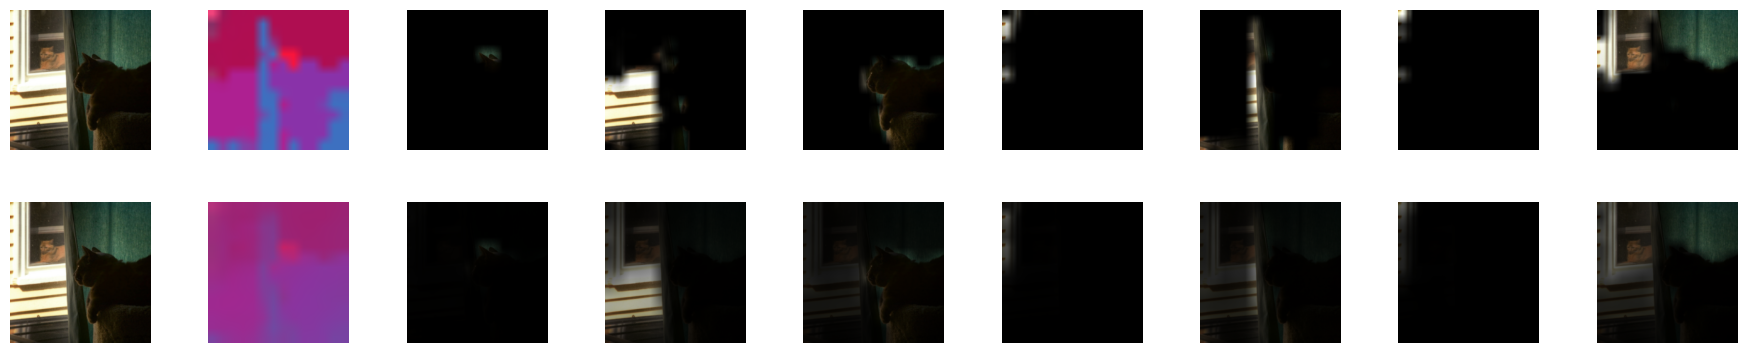

In [38]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from ocl_metrics import UnsupervisedMaskIoUMetric, ARIMetric
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

MBO_c_metric = UnsupervisedMaskIoUMetric(matching="best_overlap", ignore_background = True, ignore_overlaps = True).cuda()
MBO_i_metric = UnsupervisedMaskIoUMetric(matching="best_overlap", ignore_background = True, ignore_overlaps = True).cuda()
miou_metric = UnsupervisedMaskIoUMetric(matching="hungarian", ignore_background = True, ignore_overlaps = True).cuda()
ari_metric = ARIMetric(foreground = True, ignore_overlaps = True).cuda()

MBO_c_slot_metric = UnsupervisedMaskIoUMetric(matching="best_overlap", ignore_background = True, ignore_overlaps = True).cuda()
MBO_i_slot_metric = UnsupervisedMaskIoUMetric(matching="best_overlap", ignore_background = True, ignore_overlaps = True).cuda()
miou_slot_metric = UnsupervisedMaskIoUMetric(matching="hungarian", ignore_background = True, ignore_overlaps = True).cuda()
ari_slot_metric = ARIMetric(foreground = True, ignore_overlaps = True).cuda()

mean_vals, std_vals = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
unormalize = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ],std = [1 / std_val for std_val in std_vals]),
    transforms.Normalize(mean = [-mean_val for mean_val in mean_vals] ,std = [ 1., 1., 1. ]),
])

with torch.no_grad():
    for batch, (image, true_mask_i, true_mask_c, mask_ignore) in enumerate(tqdm(val_loader)):
        image = image.cuda()
        true_mask_i = true_mask_i.cuda()
        true_mask_c = true_mask_c.cuda()
        mask_ignore = mask_ignore.cuda() 
        
        batch_size = image.shape[0]
    
        mse, default_slots_attns, dec_slots_attns, _, _, _ = model(image)

        unorm_im = unormalize(image)

        default_attns = F.interpolate(default_slots_attns, size=args.val_mask_size, mode='bilinear')
        dec_attns = F.interpolate(dec_slots_attns, size=args.val_mask_size, mode='bilinear')

        default_attns = default_attns.unsqueeze(2)
        dec_attns = dec_attns.unsqueeze(2) # shape [B, num_slots, 1, H, W]

        pred_default_mask = default_attns.argmax(1).squeeze(1)
        pred_dec_mask = dec_attns.argmax(1).squeeze(1)

        vis_slot = F.interpolate(default_slots_attns, size=224, mode='bilinear').unsqueeze(2)[0]
        vis_dec = F.interpolate(dec_slots_attns, size=224, mode='bilinear').unsqueeze(2)[0]

        colors = torch.rand((args.num_obj, 3), dtype=torch.float32).cuda()  # Random colors for each mask
        # Overlay masks on original image
        colored_masks_dec = torch.zeros((224, 224, 3)).cuda()
        colored_masks_slot = torch.zeros((224, 224, 3)).cuda()
        for i in range(args.num_obj):
            mask_dec = vis_dec[i]
            mask_slot = vis_slot[i]
            color = colors[i]
            colored_mask_dec = (mask_dec[..., None] * color)[0]
            colored_masks_dec += colored_mask_dec
            colored_mask_slot = (mask_slot[..., None] * color)[0]
            colored_masks_slot += colored_mask_slot

        alpha = 0.8
        slot_img = [(mask *unorm_im[0]) for mask in vis_slot]
        slot_img.insert(0, colored_masks_slot.permute(2, 0, 1))
        slot_img.insert(0, unorm_im[0])

        decoder_masks = [(mask *unorm_im[0])for mask in vis_dec]
        decoder_masks.insert(0, colored_masks_dec.permute(2, 0, 1))
        decoder_masks.insert(0, unorm_im[0])

        num_col = args.num_obj+2
        num_row = 2
            
        fig, ax = plt.subplots(num_row, num_col, figsize=(num_col*2, 4))
        fig.tight_layout()

        for i in range(num_col):
            ax[0][i].imshow(slot_img[i].permute(1, 2, 0).cpu().numpy())
            ax[1][i].imshow(decoder_masks[i].permute(1, 2, 0).cpu().numpy())
            
        for i in range(num_row):
            for j in range(num_col):
                ax[i][j].grid(False)
                ax[i][j].axis("off")

        # Compute ARI, MBO_i and MBO_c, miou scores for both slot attention and decoder
        true_mask_i_reshaped = torch.nn.functional.one_hot(true_mask_i).to(torch.float32).permute(0,3,1,2).cuda()
        true_mask_c_reshaped = torch.nn.functional.one_hot(true_mask_c).to(torch.float32).permute(0,3,1,2).cuda()
        pred_dec_mask_reshaped = torch.nn.functional.one_hot(pred_dec_mask).to(torch.float32).permute(0,3,1,2).cuda()
        pred_default_mask_reshaped = torch.nn.functional.one_hot(pred_default_mask).to(torch.float32).permute(0,3,1,2).cuda()
        
        MBO_i_metric.update(pred_dec_mask_reshaped, true_mask_i_reshaped, mask_ignore)
        MBO_c_metric.update(pred_dec_mask_reshaped, true_mask_c_reshaped, mask_ignore)
        miou_metric.update(pred_dec_mask_reshaped, true_mask_i_reshaped, mask_ignore)
        ari_metric.update(pred_dec_mask_reshaped, true_mask_i_reshaped, mask_ignore)
    
        MBO_i_slot_metric.update(pred_default_mask_reshaped, true_mask_i_reshaped, mask_ignore)
        MBO_c_slot_metric.update(pred_default_mask_reshaped, true_mask_c_reshaped, mask_ignore)
        miou_slot_metric.update(pred_default_mask_reshaped, true_mask_i_reshaped, mask_ignore)
        ari_slot_metric.update(pred_default_mask_reshaped, true_mask_i_reshaped, mask_ignore)
        break
    
ari = 100 * ari_metric.compute()
ari_slot = 100 * ari_slot_metric.compute()
mbo_c = 100 * MBO_c_metric.compute()
mbo_i = 100 * MBO_i_metric.compute()
miou = 100 * miou_metric.compute()
mbo_c_slot = 100 * MBO_c_slot_metric.compute()
mbo_i_slot = 100 * MBO_i_slot_metric.compute()
miou_slot = 100 * miou_slot_metric.compute()
            
print('====> ARI = {:F} \t ARI_slots = {:F} \t mBO_c = {:F} \t mBO_i = {:F} \t miou = {:F} \t mBO_c_slots = {:F} \t mBO_i_slots = {:F} \t miou_slots = {:F}'.format(
    ari, ari_slot, mbo_c, mbo_i, miou, mbo_c_slot, mbo_i_slot, miou_slot))
            